# Boston Airbnb Listings

## Introduction
In this notebook we will be analysis the Kaggle Dataset provided by Airbnb regarding the listings of different properties in the Boston Area.  This includes a variety of different attributes, including descriptions, number of rooms/beds as well as prices on a nightly, weekly and monthly timeframe.

By going through this we are aiming to ensure that the lessons learnt in the first stage of the Udacity Datacience Nano-Degree are well understood and can apply the learning to diffrerent areas of interest.

## CRISP-DM
Following the CRISP-DM methodology we will be investigating three questions related to this data set.  These are:
* 1. How many times were specific ammenities used in advertisement of property?
* 2. Do these amenities play some impact on the pricing of the property?
* 3. Can we increase the predicted outcome of the nightly price of a dwelling based on the rest of the given dataset?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

pd.options.mode.chained_assignment = None

%matplotlib inline

df = pd.read_csv('./Data/listings.csv')

df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [2]:
print(df.dtypes)
print(df.shape)

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 95, dtype: object
(3585, 95)


Here we can see that the dataset provided is a mixture of integers, floating points and object data types.  We can also see that there are 95 seperate attributes as well as 3585 rows.

### Question 1 - How many times were specific ammenities used in advertisement of property?

#### Business Understanding
As someone looking to rent their property on Airbnb it would be beneficial to see what other properties have as ammenitites to ensure that I am meeting the percieved minimum requirements that tenants would like to see.  By doing so, we can see if future purchases are necessary to the users experience.

#### Data Understanding
Through the current dataset there is a column which shows the ammenities advertised on the Airbnb web page.  This will provide the necessary information for the pupose of this task.  We can complete a simple `value_counts` in order to list this information with the associates number this value occurs.


In [3]:
amenities = df['amenities'].value_counts().reset_index()
amenities

,index,amenities
0,{},32
1,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",15
2,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",14
3,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",14
4,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",11
...,...,...
3087,"{TV,Internet,""Wireless Internet"",Kitchen,Heati...",1
3088,"{""Cable TV"",Internet,""Wireless Internet"",""Air ...",1
3089,"{""Wireless Internet"",Kitchen,""Free Parking on ...",1
3090,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1


#### Data Preparation
By looking at this data we can see that there are different ways strings are input into the array, specifically with the use of quotation marks.  This could be because of how the input was setup in the backend or used to show an extension of the ammenity.  For example, Internet might be the ammenity and the "Wireless Internet" is the type of internet present in the accomodation.  In order to properly identity the counts of these however it will be necessary to standardise this information so they all are in the same format.

In [4]:
#create a small function to strip unnecessary characters from ammenities list
def ammendList(inputList):
    amm = inputList.str.replace('"','').str.replace('{','').str.replace('}','')
    return amm

In [5]:
#use ammendList function
amenities['index'] = ammendList(amenities['index'])
amenities

,index,amenities
0,,32
1,"TV,Cable TV,Wireless Internet,Air Conditioning...",15
2,"TV,Cable TV,Wireless Internet,Air Conditioning...",14
3,"TV,Cable TV,Internet,Wireless Internet,Air Con...",14
4,"TV,Cable TV,Internet,Wireless Internet,Air Con...",11
...,...,...
3087,"TV,Internet,Wireless Internet,Kitchen,Heating,...",1
3088,"Cable TV,Internet,Wireless Internet,Air Condit...",1
3089,"Wireless Internet,Kitchen,Free Parking on Prem...",1
3090,"TV,Cable TV,Internet,Wireless Internet,Air Con...",1


Further Data Preparation will need to be applied to this column.  We need to create a unique list of ammenities to accurately count how many times each ammenity was used in its advertisement of the property.  In order to do this we will create an array and parse each string by the comma character. 

In [6]:
def makeList(concatenatedList):
    '''
    INPUT
        concatenatedList - Series which holds multiple objects as a string
    OUTPUT
        output - unique list of which are used within the concatenatedList
    '''
    
    output = []
    
    for row in concatenatedList:
        x = row.split(',')
        for i in x:
            if i not in output:
                output.append(i)
    return output
    

In [7]:
#use the makeList function to find all uniques ammenities used
uniqueList = makeList(ammendList(df['amenities']))
uniqueList.remove('')
uniqueList

['TV',
 'Wireless Internet',
 'Kitchen',
 'Free Parking on Premises',
 'Pets live on this property',
 'Dog(s)',
 'Heating',
 'Family/Kid Friendly',
 'Washer',
 'Dryer',
 'Smoke Detector',
 'Fire Extinguisher',
 'Essentials',
 'Shampoo',
 'Laptop Friendly Workspace',
 'Internet',
 'Air Conditioning',
 'Pets Allowed',
 'Carbon Monoxide Detector',
 'Lock on Bedroom Door',
 'Hangers',
 'Hair Dryer',
 'Iron',
 'Cable TV',
 'First Aid Kit',
 'Safety Card',
 'translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50',
 'Gym',
 'Breakfast',
 'Indoor Fireplace',
 'Cat(s)',
 '24-Hour Check-in',
 'Hot Tub',
 'Buzzer/Wireless Intercom',
 'Other pet(s)',
 'Washer / Dryer',
 'Smoking Allowed',
 'Suitable for Events',
 'Wheelchair Accessible',
 'Elevator in Building',
 'Pool',
 'Doorman',
 'Paid Parking Off Premises',
 'Free Parking on Street']

#### Modelling
We now have a unique list of all the ammenities used in the Boston Airbnb Dataset as well as the Dataframe showing the unique arrays of ammenities/counts people used to advertise their homes for rent.  Using these we can count how many times each ammenity was used in the entire data set.  A small function `countOfList` was created to find the final values.  In order to adequatley display this information at the end the use of a graph, sorted by descending percentage is used.

In [8]:
def countOfList(df,col1,col2,lookup):
    '''
    INPUT
        df - dataframe to analyse
        col1 - column to check value against
        col2 - value count column
        lookup - unique list of values
    OUTPUT
        new_df - dataframe showing label and count within input dataframe
    '''
    
    new_df = defaultdict(int)
    for x in lookup:
        for i in range(df.shape[0]):
            if x in df[col1][i]:
                new_df[x]+=int(df[col2][i])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('amenities', ascending=False, inplace=True)
    return new_df
    

In [9]:
#use countOfList function
amenities_df = countOfList(amenities, 'index','amenities',uniqueList)
amenities_df

,index,amenities
15,Internet,3459
1,Wireless Internet,3421
6,Heating,3384
2,Kitchen,3284
12,Essentials,2994
9,Dryer,2993
10,Smoke Detector,2911
16,Air Conditioning,2821
0,TV,2725
8,Washer,2475


In [10]:
#set the data frame index
amenities_df.set_index('index', inplace=True)

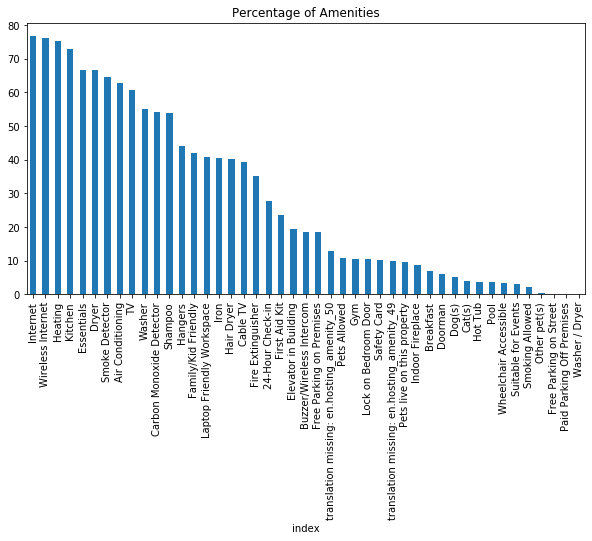

In [11]:
#create plot showing percentage each ammenitiy was used in the entire boston airbnb dataset
(amenities_df/amenities_df.shape[0]).plot(kind='bar', legend=None, figsize=(10,5));
plt.title("Percentage of Amenities");
plt.show();

#### Evaluation
Here we can see that the majority of people who are using Airbnb as a platform to rent out their property believe that things such as Internet and Heating have an impact on their ability to sell the property.  However, this may not be the case.  The next step i understanding the impact these have on the price the property rents out for is to see if we can predict the price based on these attributes.

### Question 2 - Do these amenities play some impact on the pricing of the property?

#### Business Understanding
Although it is important to understand how often the ammenity was added in the Boston Airbnb Dataset, it would be beneficial to understand if the choice of ammenities is significant in how much the property could be rented for on a nightly basis.  This would allow the landlord to make small purchases to increase their bottom line.

#### Data Understanding
Through the current dataset we are able to use the ammenities and the price columns.  This will allow us to check each ammenity (similar to Question 1) against the price to see if there is any correlation.  We can also asses the data types in each column using the `dtypes` command to see if the column appears to allign with our needs.

In [12]:
#create new dataframe
am_price_df = df[['amenities','price']]

#find data types and view data frame
print(am_price_df.dtypes)
am_price_df

amenities    object
price        object
dtype: object


,amenities,price
0,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$250.00
1,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$65.00
2,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",$65.00
3,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$75.00
4,"{Internet,""Wireless Internet"",""Air Conditionin...",$79.00
...,...,...
3580,"{Internet,""Wireless Internet"",""Air Conditionin...",$69.00
3581,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$150.00
3582,"{""translation missing: en.hosting_amenity_49"",...",$198.00
3583,"{Kitchen,Gym,""Family/Kid Friendly"",Washer,Drye...",$65.00


#### Data Preparation
Similar to Question 1 there are a variety of different characters which need to be removed in order to create a standard format throughout the DataFrame.  Specifically for the price column we need to change the object type to a float.  We can create a small function to remove symbols such as columns and dollar signs.

In [13]:
#small function to strip unneccessary characters from price column and create a float
def cleanCost(inputList):
    amm = inputList.str.replace(',','').str.replace('$','').astype('float')
    return amm

In [14]:
#use cleanCost function
am_price_df['price'] = cleanCost(am_price_df['price'])

In [15]:
#use ammendList function
am_price_df['amenities'] = ammendList(am_price_df['amenities'])
am_price_df

,amenities,price
0,"TV,Wireless Internet,Kitchen,Free Parking on P...",250.0
1,"TV,Internet,Wireless Internet,Air Conditioning...",65.0
2,"TV,Cable TV,Wireless Internet,Air Conditioning...",65.0
3,"TV,Internet,Wireless Internet,Air Conditioning...",75.0
4,"Internet,Wireless Internet,Air Conditioning,Ki...",79.0
...,...,...
3580,"Internet,Wireless Internet,Air Conditioning,Ki...",69.0
3581,"TV,Internet,Wireless Internet,Air Conditioning...",150.0
3582,"translation missing: en.hosting_amenity_49,tra...",198.0
3583,"Kitchen,Gym,Family/Kid Friendly,Washer,Dryer,E...",65.0


Now that we have the data in a simple format we need to transition this into a new dataframe which uses 1/0 encoding.  This will allow us to complete regressions based on each property having a unique ammenity.  We will run through each name in the unique list discovered in Question 1 and if the ammenity is present in the advertisement array we will place a 1, else a 0.  Once this is complete we will need to drop the ammenities column to tidy up the Dataframe.

In [16]:
#for each element in unique list create a 1/0 encoding
for col in uniqueList:
    am_price_df[col]=0
    for i in range(am_price_df.shape[0]):
        if col in am_price_df['amenities'][i]:
            am_price_df[col][i]=1
        else:
            am_price_df[col][i]=0

am_price_df.head()

,amenities,price,TV,Wireless Internet,Kitchen,Free Parking on Premises,Pets live on this property,Dog(s),Heating,Family/Kid Friendly,...,Other pet(s),Washer / Dryer,Smoking Allowed,Suitable for Events,Wheelchair Accessible,Elevator in Building,Pool,Doorman,Paid Parking Off Premises,Free Parking on Street
0,"TV,Wireless Internet,Kitchen,Free Parking on P...",250.0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,"TV,Internet,Wireless Internet,Air Conditioning...",65.0,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,"TV,Cable TV,Wireless Internet,Air Conditioning...",65.0,1,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,"TV,Internet,Wireless Internet,Air Conditioning...",75.0,1,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,"Internet,Wireless Internet,Air Conditioning,Ki...",79.0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#drop the ammenities column from the data frame
am_price_df = am_price_df.drop('amenities', axis=1)
am_price_df

,price,TV,Wireless Internet,Kitchen,Free Parking on Premises,Pets live on this property,Dog(s),Heating,Family/Kid Friendly,Washer,...,Other pet(s),Washer / Dryer,Smoking Allowed,Suitable for Events,Wheelchair Accessible,Elevator in Building,Pool,Doorman,Paid Parking Off Premises,Free Parking on Street
0,250.0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,65.0,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,65.0,1,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,75.0,1,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,79.0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,69.0,0,1,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3581,150.0,1,1,1,1,1,0,1,1,1,...,0,0,1,0,0,1,0,0,0,0
3582,198.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3583,65.0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


#### Modelling
We now have a dataframe in a 1/0 encoded format we are able to conduct some linear regressions.  We will use the `sklearn` library to split the dataset into training and testing sections as well as using the linear regression model.  We will then test the accuracy of the model using the r-squared method

In [18]:
X = am_price_df.drop('price',axis=1)
y = am_price_df['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 

#Rsquared and y_test
rsquared_score = r2_score(y_test, y_test_preds)
length_y_test = len(y_test)

"The r-squared score for your model was {} on {} values.".format(rsquared_score, length_y_test)

'The r-squared score for your model was 0.10650576585003213 on 1076 values.'

#### Evaluation
Here we can see that there is currently not enough information which will allow us to predict the outcome of the price based purely on the amenities.

### Question 3 - Can we increase the predicted outcome of the nightly price of a dwelling based on the rest of the given dataset?

#### Business Understanding
From Question 2 it shows that ammenities are not enough to predict the price per night.  However as someone hoping to plave their property for rent on Airbnb it would be beneficial to understand how much I could rent my property for based on other data points (such as square feet).  This would allow for users to quickly check if it is worth their time based on their property type and design.

#### Data Understanding
Through the current dataset we can use the price column as the outcome to predict whilst using the other columns to try and predict the price.  In order to see which attributes respond to different prices we can conduct a simple pearson coorrelation test and view the results as a heatmap. 

In [19]:
#clean the prices
df[['price','security_deposit','cleaning_fee']] = df[['price','security_deposit','cleaning_fee']].apply(cleanCost, axis=0)

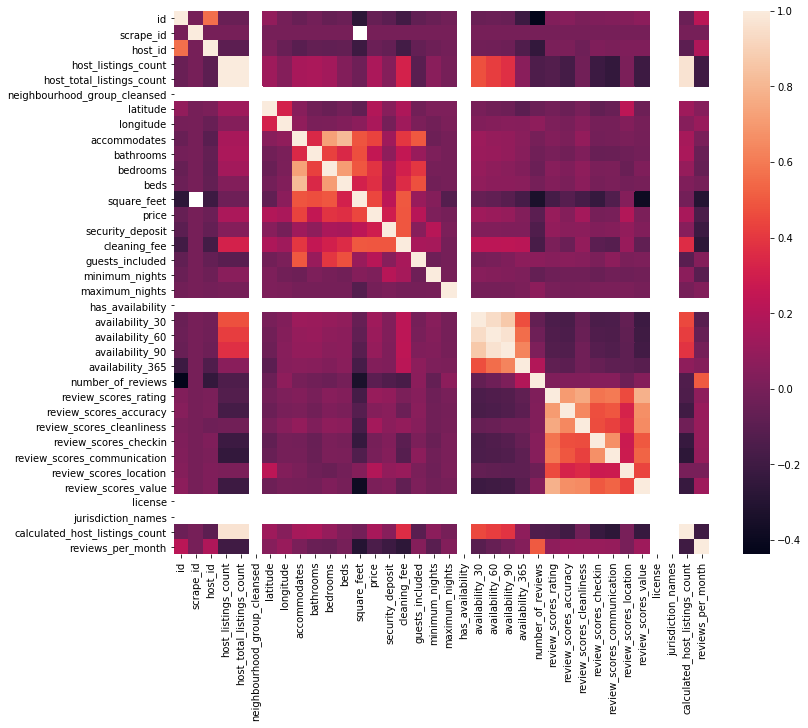

In [20]:
#show heatmap correlation
fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(df.corr(),ax=ax);

In [21]:
#create small dataframe for testing purposes
df_test = df[['price','accommodates','bathrooms','bedrooms','beds','security_deposit','cleaning_fee','guests_included','neighbourhood_cleansed']]

#### Data Preparation
In order to prepare the data for regression we will need to drop all rows where the price column has a `na` value.  We will need to place the median value on all numeric values where there is a `na` value.  We will also need to create dummy variables for each of the catagorical vairbale to produce 1/0 encoding.  This will allow us to perform linear regressions similar to Question 2. 


In [22]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector

    '''
    # Drop rows with missing salary values
    df = df.dropna(subset=['price'], axis=0)
    y = df['price']
    
    #Drop respondent and expected salary columns
    df = df.drop('price', axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    #Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        #for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    


#### Modelling
We will be using a Linear Regression Model in orde to predict the price per night of accomodation based upon the provided attributes.  We will be assessing the effectiveness of the model by evaluatin the r-squared score.  We will also view the coefficient weighting of the model in order to see which attribute was the most important in assessing the total price outcome.

In [23]:
def clean_fit_linear_mod(df, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    '''
    
    #Use the function to create X and y
    X, y = clean_data(df)

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test


In [24]:
#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df_test, dummy_na=False)

In [25]:
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.39149907652546745.  The rsquared on the test data was 0.2731991293005437.


In [26]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = coefficients
    coefs_df['abs_coefs'] = np.abs(coefficients)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df



In [27]:
#Use the function
coef_df = coef_weights(lm_model.coef_, X_test)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
27,neighbourhood_cleansed_South Boston Waterfront,158.941177,158.941177
7,neighbourhood_cleansed_Back Bay,120.243932,120.243932
9,neighbourhood_cleansed_Beacon Hill,112.819347,112.819347
8,neighbourhood_cleansed_Bay Village,105.336617,105.336617
14,neighbourhood_cleansed_Downtown,96.155699,96.155699
16,neighbourhood_cleansed_Fenway,93.690755,93.690755
19,neighbourhood_cleansed_Leather District,88.161283,88.161283
28,neighbourhood_cleansed_South End,82.179300,82.179300
12,neighbourhood_cleansed_Chinatown,81.130790,81.130790
11,neighbourhood_cleansed_Charlestown,64.432090,64.432090


#### Evaluation
Here we can see that we have improved the accuracy of the prediction by using a subset of the information from the Boston Airbnb Dataset. Furthermore, we are able to see which variables had the largest weighting on the price outcome, with the `neighbourhood_cleansed` variable beeing the most important part.  Further assessments should involve looking at more attributes in order to try and improve the accuracy of the model